# Check and visualization of the persistence layer.

We first provide a small test unit and then visualize the Gaussians on a simple train/test problem. 

In [1]:
import numpy              as np
np.set_printoptions(threshold='nan')
import math       
import sys
import random             as rd
import matplotlib.pyplot  as plt
import matplotlib.image   as mpimg
import pickle
import gudhi      as gd
import tensorflow as tf
import _persistence_vector_grad
persistence_vector_module = tf.load_op_library('persistence_vector.so')
import _persistence_vector_essential_grad
persistence_vector_essential_module = tf.load_op_library('persistence_vector_essential.so')

# Test Unit

In [2]:
# Here you can specify the input
# In this case, we have two persistence diagrams:
# - one with a single point with coordinates (0,1)
# - one with two points with coordinates (0,2) and (1,3)
data = tf.Variable([[0.0,1.0],[0.0,2.0],[1.0,3.0]])
card = tf.Variable([[1.0],[2.0]])

# Here you can specify the Gaussian to use
# In this case, we have two Gaussians:
# - one with center (0,0) and sharpnesses (1,1)
# - one with center (1,1) and sharpnesses (1,1)
G    = tf.Variable([[0.0,0.0,1.0,1.0],
                    [1.0,1.0,1.0,1.0]])

# Nu value for the persistence layer
nu   = tf.Variable([[0.1]])

# Computation of the layer
v = persistence_vector_module.persistence_vector(data, card, G, nu)

# The loss is the sum of each entry of the persistence layer
loss = v[0,0] + v[1,0] + v[0,1] + v[1,1]

# The gradient is defined w.r.t. the previous loss, 
# so you can change the loss to check other gradient values
train = tf.train.GradientDescentOptimizer(0.1)
grad = train.compute_gradients(loss, G)

# Check values
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(v))
    print(sess.run(grad[0][0]))

[[0.36787945 0.84233886]
 [0.01836104 0.739291  ]]
[[ 0.57232136  0.57219297 -0.4418684  -0.44132358]
 [ 0.20318118  0.11901799 -0.58695483 -0.39820704]]


# Gaussian visualization on a simple problem 

Here, we visualize how the Gaussians move during Gradient Descent. The problem to solve is very simple: we generate persistence diagrams from two classes by sampling points with two different probability distributions, and try to classify a diagram according to what distribution was used to generate it with a small Neural Net composed of the persistence layer and a fully connected layer. 

## Network definition

In [30]:
# Number of labels
num_labels = 2

# Number of Gaussians
numgauss   = 2

# Placeholders
data   = tf.placeholder(tf.float32, shape=[None, 2])
card   = tf.placeholder(tf.float32, shape=[None, 1])
label  = tf.placeholder(tf.float32, shape=[None, None])

# Gaussian initializations are close to the centers of the probability distributions
mu0    = tf.Variable(tf.random_uniform([numgauss], minval=22/np.sqrt(2)-2, maxval=22/np.sqrt(2)+2)) 
mu1    = tf.Variable(tf.random_uniform([numgauss], minval=18/np.sqrt(2)-2, maxval=18/np.sqrt(2)+2)) 
sigma0 = tf.Variable(tf.truncated_normal([numgauss], mean=0, stddev=0.1))
sigma1 = tf.Variable(tf.truncated_normal([numgauss], mean=0, stddev=0.1))
G      = tf.concat([tf.reshape(mu0,[numgauss,1]), tf.reshape(mu1,[numgauss,1]), 
                    tf.reshape(sigma0,[numgauss,1]), tf.reshape(sigma1,[numgauss,1])],1)
nu_tensor  = tf.Variable([[0.01]], trainable=False)

# Persistence layer
v = persistence_vector_module.persistence_vector(data, card, G, nu_tensor)

# Fully connected layer
W    = tf.Variable(tf.random_uniform([numgauss,num_labels]))
b    = tf.Variable(tf.random_uniform([num_labels]))
w    = tf.matmul(v, W) + b

## Method

In [31]:
# Prediction
correct_prediction   = tf.equal(tf.argmax(w, 1), tf.argmax(label, 1))
accuracy             = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# We use Gradient Descent with a fixed learning rate of 0.1 to minimize cross entropy
train                = tf.train.GradientDescentOptimizer(0.1)
cross_entropy        = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=label, logits=w))
train_step           = train.minimize(cross_entropy)

# Gradients w.r.t. the Gaussians
gradmu0              = train.compute_gradients(cross_entropy, mu0)
gradmu1              = train.compute_gradients(cross_entropy, mu1)
gradsigma0           = train.compute_gradients(cross_entropy, sigma0)
gradsigma1           = train.compute_gradients(cross_entropy, sigma1)

## Optimization

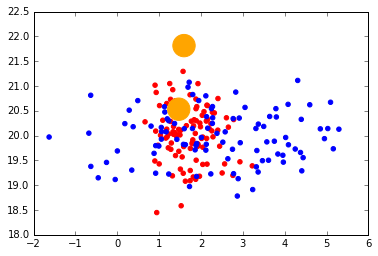

0.95


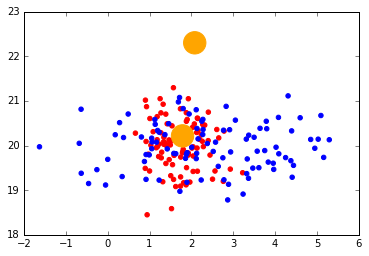

In [34]:
data_PD  = []
card_PD = []
label_PD = []
color = []

# Draw first class of 10 red persistence diagrams
# with 10 points sampled with a normal distribution centered on (1.75,20)
for i in range(10):
    D = np.random.normal(loc=[1.75, 20.0], scale=[0.5, 0.5], size=(10,2))
    data_PD.append(D)
    card_PD.append(10)
    
    label_PD.append(np.array([1, 0]))
    for _ in range(10):
        color.append("red")

# Draw second class of 10 blue persistence diagrams 
# with 10 points sampled with a normal distribution centered (2.25,20)
for i in range(10):
    D = np.random.normal(loc=[2.25, 20.0],  scale=[1.5, 0.5], size=(10,2))
    data_PD.append(D)
    card_PD.append(10)
    
    label_PD.append(np.array([0, 1]))
    for _ in range(10):
        color.append("blue")

# Color Gaussians in orange
colorg = []  
for _ in range(numgauss):
    colorg.append("orange")
        
# Reshape data for dimensionality agreement
data_conc = np.concatenate(data_PD,0)
card_conc = np.reshape(card_PD,(-1,1))

# Visualize dataset
plt.scatter(data_conc[:,0], data_conc[:,1], color=color)
    
with tf.Session() as sess:

    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Visualize Gaussian initialization
    M0 = mu0.eval()
    M1 = mu1.eval()
    S0 = sigma0.eval()
    S1 = sigma1.eval()
    plt.scatter((M0-M1)/np.sqrt(2),(M0+M1)/np.sqrt(2), color=colorg,s=500)
    plt.show()
    
    # Do 100 rounds of Gradient Descent
    for ep in range(100):
        train_step.run(feed_dict={data: data_conc, card: card_conc, label: np.array(label_PD)})
    
    # Visualize Gaussians after Gradient Descent
    M0 = mu0.eval()
    M1 = mu1.eval()
    S0 = sigma0.eval()
    S1 = sigma1.eval()
    plt.scatter(data_conc[:,0], data_conc[:,1], color=color)
    plt.scatter((M0-M1)/np.sqrt(2),(M0+M1)/np.sqrt(2),color=colorg,s=500)
    plt.show()